In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helper as hp

In [2]:
def fGenerator(frequency, samplingRate):
    
    def f(n):        
        return np.cos(2*np.pi*frequency/samplingRate*n)
    
    return f

In [3]:
BASE = 2000
DEVIATION = 2000
SAMPLING_RATE = 22050

SAMPLES_PER_SYMBOL = 400
BETA = 1/2


def phi(i):
    return fGenerator(BASE + i*DEVIATION, SAMPLING_RATE)

# ! Dans le raised cosine, la period influence tout, notamment l'amplitude du signal temporel et la bandwith du signal 1/2T
def raised_cosine(beta, period):
    
    def f(n):
        return (4*beta)/(np.pi*np.sqrt(period)) \
        *(np.cos((1+beta)*np.pi*n/period) + (1-beta)*np.pi/(4*beta)*np.sinc((1-beta)*n/period))/ \
        (1-np.square((4*beta*n/period))) + \
        (np.abs(n) == period/(4*beta))
        
    
    limit_raised_cosine_critical_points = \
    beta/(np.pi*np.sqrt(2*period))*((np.pi + 2)*np.sin(np.pi/(4*beta)) + (np.pi-2)*np.cos(np.pi/(4*beta)))
    
    def g(n):
        
        return np.piecewise(float(n), [(np.abs(n) != period/(4*beta)), (np.abs(n) == period/(4*beta))], \
                           [lambda x : f(x), lambda x : limit_raised_cosine_critical_points])
    
    return g

def waveformer(n):
    return raised_cosine(BETA, SAMPLES_PER_SYMBOL)(n-SAMPLES_PER_SYMBOL/2)*(phi(0)(n) + phi(1)(n) + phi(2)(n) + phi(3)(n))

def altered_waveformer(n):
    return raised_cosine(BETA, SAMPLES_PER_SYMBOL)(n-SAMPLES_PER_SYMBOL/2)*(phi(0)(n) + phi(1)(n) + phi(3)(n))

def minimalist_waveformer(n):
    return raised_cosine(BETA, SAMPLES_PER_SYMBOL)(n-SAMPLES_PER_SYMBOL/2)*(phi(0)(n) + phi(1)(n))

def altered_minimalist_waveformer(n):
    return raised_cosine(BETA, SAMPLES_PER_SYMBOL)(n-SAMPLES_PER_SYMBOL/2)*(phi(0)(n))

In [4]:
# ! Le résultat n'est pas normalisé !
def generic_encoder(bool_message, samples_per_symbol, f):
    
    result = []
    
    for s in bool_message:
        for i in range(samples_per_symbol): # range est exclusif: va de 0 à n-1, soit n symboles en tout
            result.append((1 if s else -1)*f(i))
    
    #print("LENGTH SENT MESSAGE" +str(len(result)))
    return result

In [5]:
def generic_decoder(float_message, samples_per_symbol, length_of_bool_message, synchro_shift, f):
    
    synchronised_message = float_message[synchro_shift:synchro_shift + samples_per_symbol*length_of_bool_message]
    
    result = []
    
    #print(len(synchronised_message))
    
    assert len(synchronised_message)%samples_per_symbol == 0
    #length = int(len(float_message)/samples_per_symbol)
    length = length_of_bool_message
    
    decoding_vector = generic_encoder([True],samples_per_symbol, f)
    
    for i in range(length):
        
        currentSymbol = synchronised_message[i*samples_per_symbol:(i+1)*samples_per_symbol]
        
        y = np.dot(decoding_vector, currentSymbol)
        #print(y)
        
        result.append(y>0)
    
    return result

In [6]:
def synchro_seq_generator(seed, length):
    
    np.random.seed(seed)
    
    bool_sequence = np.random.randint(2, size = length)
    
    return bool_sequence

# Version 5: New version of synchronizer
def synchronizer(float_message, preambule_matcher, postbule_matcher, length_of_bool_message, samples_per_symbol, f):
    
    preambule_float = generic_encoder(preambule_matcher, SAMPLES_PER_SYMBOL, f)
    
    postbule_float = generic_encoder(postbule_matcher, SAMPLES_PER_SYMBOL, f)
    
    matcher = np.concatenate((preambule_float, np.zeros(length_of_bool_message*samples_per_symbol), postbule_float))
    
    return np.argmax(np.correlate(float_message, matcher, "valid"))

In [7]:
def create_send_file(preambule, boolean_message, postbule, path, f):

    #print(len(boolean_message))
    #print(len(preambule))
    #print(len(np.concatenate((preambule,boolean_message))))
    
    sent_test_message = generic_encoder(np.concatenate((preambule,boolean_message,postbule)), SAMPLES_PER_SYMBOL, f)

    normalized_sent_test_message = sent_test_message/np.max(sent_test_message)
    
    print("LENGTH SENT MESSAGE =" + str(len(normalized_sent_test_message)))

    #plt.plot(np.arange(0,100,1), sent_test_message[:100])
    plt.plot(np.abs(np.fft.fft(normalized_sent_test_message)))

    fd = open(path, "w")
    for fl in sent_test_message:
        fd.write(str(fl))
        #fd.write(str(fl*np.random.normal(1,0.1))) # AJOUT DE BRUIT ARTIFICIEL POUR TEST UNIQUEMENT
        fd.write("\n")

    fd.close()

In [8]:
def decode_file(preambule, length_bool_message, postbule, path, f):
    result_message = []

    with open(path,"r") as fr:  
        for cnt, line in enumerate(fr):
            result_message.append(float(line))

    fr.close()
    
    delay_index = synchronizer(result_message, preambule, postbule, length_bool_message, SAMPLES_PER_SYMBOL, f)
    
    #print("DELAY = " + str(delay_index))
    
    synchro_shift = delay_index + len(preambule)*SAMPLES_PER_SYMBOL
    
    result_bool_message = generic_decoder(result_message, SAMPLES_PER_SYMBOL, length_bool_message, synchro_shift, f)

    plt.plot(np.abs(np.fft.fft(result_message[delay_index:delay_index+(len(preambule)+length_bool_message)*SAMPLES_PER_SYMBOL])))
    
    print("LENGTH RECIEVED MESSAGE =" + str(len(result_message)))
    print("DELAY =" + str(delay_index))
    print("FFT show " + str(delay_index) + " to " + str(delay_index+(len(preambule)+length_bool_message+len(postbule))*SAMPLES_PER_SYMBOL))
    print("Preambule = ", preambule)
    
    return result_bool_message
    

#recieved_test_message = generic_decoder(result_message, SAMPLES_PER_SYMBOL, len(test_message), 0,f)

#print(recieved_test_message)

LENGTH SENT MESSAGE =675200
MESSAGE SENT


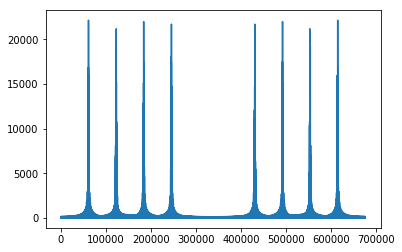

In [9]:
#test_message = [True, False, False, True, False, True, True, True, True, False, False, True]
test_message = hp.read_file("test_input.txt")

preambule = synchro_seq_generator(43, 16)

postbule = synchro_seq_generator(57, 16)

#mock_delaying_sequence = synchro_seq_generator(18,10) # TESTS: introduit un faux décalage pour tester l'effet de ce dernier.

#mock_post_sequence = synchro_seq_generator(18,5) # TESTS

#print("MOCK_DELAYING_SEQUENCE =", mock_delaying_sequence)

#TESTS: ENCODAGE AVEC UNE VERSION ALTEREE DE L'ENCODER
#create_send_file(np.concatenate((mock_delaying_sequence,preambule)), test_message, np.concatenate((postbule,mock_post_sequence)), "test_message.txt", altered_waveformer)
create_send_file(preambule, test_message, postbule, "test_message.txt", waveformer)

print("MESSAGE SENT")


LENGTH RECIEVED MESSAGE =683954
DELAY =8295
FFT show 8295 to 683495
Preambule =  [0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0]


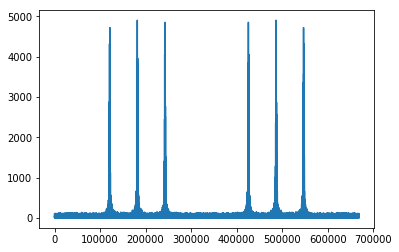

In [11]:
# Documents/JupyterNotebooks/PDCProject/PDC-Project/Cedric_dev

#python client.py --input_file=test_message.txt --output_file=test_result.txt --srv_hostname=iscsrv72.epfl.ch --srv_port=80

resultat = decode_file(preambule, len(test_message), postbule, "test_result.txt", waveformer)

hp.write_file(resultat, "test_output.txt")